In [1]:
#purpose is to scale images for use for determining proper motions etc, first collecting some files
'''
Paths and file needs:
*paths to all images and data for epoch 1
'''
#now the steps
'''
1) read in all the data by noting all the paths to given spitzer and hubble images
2) multiply images by scale or check in ds9
3) inspect outputs in python and ds9...not a lot here, but it is tough work!
'''

#just to check python version - should be 3.8.x
from platform import python_version
print(python_version())

#importing libraries
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel, Box2DKernel
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import glob
import itertools
import matplotlib 
%matplotlib inline
matplotlib.use('Agg') #invokved b/c just plain matplotlib was insufficient
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

#this part is only if you're scripting and want switches, EX:
# switch1 = 'on' #convolving images [needed to put it on for switch 3 at min...need to figure out other solution, eh]
# switch1b = 'on' #regridding...
# switch2 = 'on' #solving equations
# switch3 = 'on' #plotting / graphics of solutions

3.8.13


In [2]:
# #finding the path to every fits images in a directory
def im_name_finder(path, file_type):
    #Using glob (it's a unix command similar to ls)
    #WARNING: using recursive=True...depending how many images you use this could be very slow, it's recommended not to have too many subfolders
    #if needed, some example code is commented towards the latter half of this code that could help make an alternative
    all_names = glob.glob(path, recursive=True)

    #IMPORTANT: Using "fit" here because it is inclusive of both fits and FIT...some files end in "FIT" and need to be included
    #using s.lower() include uppercase names
    im_names = [s for s in all_names if 'fit' in s.lower()]

    return im_names


#if you'd like to try convolving the images...some options
'''now convolve my image with a PSF of the image we're projecting ONTO
an approx PSF can be found by assuming a 2D Gaussian func with a width (a FWHM) of the diffrac limit
that is the st dev of the Gaussian is about the st dev is about = lambda/D
a list of PSFs are found on https://docs.astropy.org/en/stable/convolution/kernels.html

Notes:
FIRST: always must convert hdu1_pixtorad to radians! It's inconsistent otherwise, and lambda/D is generally in radians

what we're using for the gaussian width is the FWHM, not the radius of the first ring of the diffraction pattern,
so it's 1.2 not 1.22 times lambda/D

D is 85 cm for spitzer
D is 2.4 m for hubble
'''

def im_conv(D, hdu_pix_torad, hdu_dat, lam, kern):
    #gaussian kernel
    if kern == 'gauss':
        #update: usually cannot find wavelength but these headers are well-labeled    
        #finding angular resolution...the FWHM of our Gaussian PSF
        res = 1.2 * lam / D         #resolution in radians
        res = res / hdu_pix_torad        #so converting to pixels

        #finding PSF and then calculating the convolution of our image and the PSF of the image we're projecting onto
        kernel = Gaussian2DKernel(res)

    #box kernel
    if kern == 'box':
        kernel = Box2DKernel(16.)

    hdu_conv = convolve(hdu_dat, kernel)
    return hdu_conv

# In[27]:

#a new fits file to be saved and viewed in DS9
def fits_saver(array, wcs_header, name, save_path):
    '''
    array is a 2d array of data - could be from reprojecting one image onto another or from convolution
    wcs_header is a header containing the wcs coords of the image that we projected onto or of the orig image (if from the convolution)
    name is the path to some image you're using. It will get string split at the / character, and the func only takes the last element of that splitting
    save_path is the folder you want to save to...recommended to also add something to the start of the images names to make it clear what you did to them (e.g. 'Regridded/regrid_')
    '''

    #creating a new file and adding the reprojected array of data as well as the WCS that we projected onto
    hdu_new = fits.PrimaryHDU(array, header=wcs_header)
    hdul = fits.HDUList([hdu_new])
    
    #saving the file
    if name.find('FIT') == -1: #needed if file end incorrect
        new_filename = name.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True)
    else:
        name_fixfit = name[:-3] + 'fits'
        new_filename = name_fixfit.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True)
        
    return (save_path+new_filename)

In [3]:
#paths to epoch 1 and epoch 2 data processed with IPAC Montage
# path = '../../Montage_results/n2071_headercut/*drz.fits' # #using ** will grab all files even in subdirectories WARNING takes longer
# path = '../../Montage_results/n2071_headercut_rotated/*drz.fits'
path = '../../drizzle_ngc2071/aer_dropsize_combineMethods/16*updated*pos*'
im_names_n2071 = sorted(im_name_finder(path, 'fit')) #im_finder is basically glob.glob
im_names_n2071 = [i.replace('\\', '/') for i in im_names_n2071]
print(im_names_n2071)

['../../drizzle_ngc2071/aer_dropsize_combineMethods/160w_updated_pos.fits', '../../drizzle_ngc2071/aer_dropsize_combineMethods/164n_updated_pos.fits', '../../drizzle_ngc2071/aer_dropsize_combineMethods/167n_updated_pos.fits']


In [4]:
#reading in data
hdu_list = [fits.open(i) for i in im_names_n2071] #opening fits from paths

#initializing some lists to be used
hdu_pix_list = []
hdu_pixtorad_list = []
# hdu_fnu_list = []
hdu_lam_list = []
hdu_flam_list = []
hdu_bw_list = []
hdu_data_list = []
hdu_header_list = []

#actually reading in the data
count = 0
for hdu_data in hdu_list:   
    #reading in conversions
    hdu_pix_list.append(hdu_data[0].header['D001SCAL'])  #D001SCAL is the keyword for Hubble images, in sr
    hdu_pixtorad_list.append(hdu_pix_list[count] / 206265.)
    # hdu_fnu_list.append(hdu_units[0].header['PHOTFNU'])
    hdu_lam_list.append(hdu_data[0].header['PHOTFLAM'])
    # hdu_flam_list.append(hdu_data[0].header['PHOTFLAM'])
    hdu_bw_list.append(hdu_data[0].header['PHOTBW'])

    #reading in data for general use  and header for wcs
    #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
    hdu_data_list.append(hdu_data[1].data * hdu_data[0].header['PHOTFLAM'] * hdu_data[0].header['PHOTBW'])
    hdu_header_list.append(hdu_data[1].header)
    
    count+=1

In [5]:
hdu_lam_list = [1.64, 1.67, 1.60]

print(hdu_lam_list)
print(sorted(hdu_lam_list))

# ind_lam_short = hdu_lam_list.index(12831.845)
# print(ind_lam_short)
# ind_lam_long = hdu_lam_list.index(16641.6)
# print(ind_lam_long)

[1.64, 1.67, 1.6]
[1.6, 1.64, 1.67]


In [6]:
#convolving, if you'd like to
D = 2.4 * 1e10 #m to angstrom for hubble, is unit of wavelength from header

#convolving images
hdu_conv_list = []
for i in range(len(hdu_data_list)):
    hdu_im_conv = im_conv(D, 6.2298558e-7, hdu_data_list[i], 16700, 'gauss')
    
#     if hdu_lam_list[i] > 15000.:
#         hdu_im_conv = im_conv(D, hdu_pixtorad_list[1], hdu_data_list[i], hdu_lam_list[1], 'gauss')
#     else:
#         hdu_im_conv = im_conv(D, hdu_pixtorad_list[5], hdu_data_list[i], hdu_lam_list[5], 'gauss')
    hdu_conv_list.append(hdu_im_conv)

In [7]:
#saving convolved images
save_path = '../../Convolved_Images_Hub/conv_'
for i in range(len(hdu_conv_list)):
    hdu_header_list[i]['HISTORY'] = 'Image was convolved. Units have not been converted, not regridded, etc. If wavelength is > 15000 angstrom, it was regridded with a gaussian psf with res ~ 1.2 * 12831.845 angstrom / Hubble diameter. Otherwise (lam < 15000 angstrom), the wavelength used was 16641.6.'
    conv_path = fits_saver(hdu_conv_list[i], hdu_header_list[i], im_names_n2071[i], save_path)

FileNotFoundError: [Errno 2] No such file or directory: '../../Convolved_Images_Hub/conv_160w_updated_pos.fits'

In [8]:
#an example plotting function to play with
def implot(data, w, wcscond, vmax_p):
    fig = plt.figure()
    
    if  wcscond == True:
        fig.add_subplot(111, projection=w)
    else:
        fig.add_subplot(111)
    
    #for christmas turn on GnRd
    #plt.cm.get_cmap('Blues', 6) is another option
    #can also use RdBu...
    #otherwise just use plt.cm.viridis b/c it works
    plt.imshow(data, origin='lower', cmap=plt.cm.viridis, vmin =0, vmax=vmax_p)
    plt.xlabel('RA')
    plt.ylabel('Dec')


# Testing behavior of astropy norms, stretches

In [9]:
%matplotlib inline

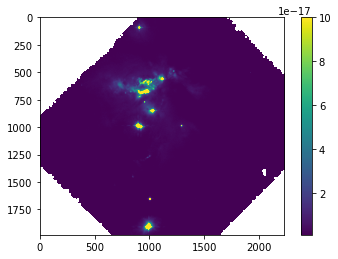

In [10]:
from astropy import wcs
from astropy.visualization import simple_norm
from scipy import ndimage

img = hdu_data_list[2]
# img = ndimage.rotate(hdu_data_list[2], 5)
norm=simple_norm(img, 'sqrt')

fig = plt.figure()
im = plt.imshow(img, vmin=1e-18, vmax=1e-16)
fig.colorbar(im)

# implot(hdu_data_list[0], wcs.WCS(hdu_header_list[0]), False, 1e-16)
# implot(hdu_im_conv, wcs.WCS(hdu_header_list[0]), False, 1)

C:\Users\arubi\AppData\Local\Temp\ipykernel_5104\3136072387.py:5: RuntimeWarning: divide by zero encountered in true_divide
  plt.imshow(img/interval(img))


'img_norm_epoch1.fits'

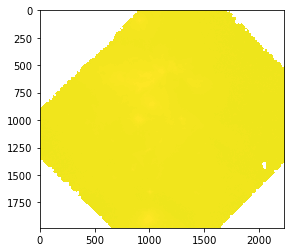

In [11]:
from astropy.visualization import MinMaxInterval
interval = MinMaxInterval()
interval.get_limits(img)
interval(img)
plt.imshow(img/interval(img))
fits_saver(interval(img), hdu_header_list[2], 'img_norm_epoch1.fits', '')

In [12]:
normed_img_list = []

for i in hdu_data_list:
    normed_img_list.append(interval(img))

# Trying a linear combination of the image set to create a synthetic 160 image

In [13]:
#NOTE: this cell can be skipped, it was just testing if we could solve the scaling issue pixel by pixel

#one example way to do it is to section the image and take averages...
#note scipy.optimize.minimize only takes 1d vectors to fit, so just fitting row by row...
from scipy.optimize import minimize

def cont_scale_equ(scale_arr, ind1, ind2):
    #here we setup the appropriate pixel we are fitting and then set it to 0 if nan!
    img_164 = np.nan_to_num(hdu_data_list[0][ind1, ind2])
    img_167 = np.nan_to_num(scale_arr * hdu_data_list[1][ind1, ind2])
    img_160_tosolve = np.nan_to_num(hdu_data_list[2][ind1, ind2])
    
    return np.sum(np.sqrt((img_164+img_167)**2. - (img_160_tosolve)**2.) )

#taking an example image and looping through rows to fit the linear equation row by row
x0 = 0.45 * np.ones(hdu_data_list[1].shape)
scale_fit = np.ones(hdu_data_list[1].shape)
for i in range(x0.shape[0]):
    for j in range(x0.shape[0]):
        min_img_sol = minimize(cont_scale_equ, [x0[i,j]], args=(i, j))
        scale_fit[i,j] = min_img_sol.x

C:\Users\arubi\AppData\Local\Temp\ipykernel_5104\94535282.py:13: RuntimeWarning: invalid value encountered in sqrt
  return np.sum(np.sqrt((img_164+img_167)**2. - (img_160_tosolve)**2.) )


KeyboardInterrupt: 

In [14]:
#NOTE: this cell can be skipped, it was just testing if we could solve the scaling issue pixel by pixel

#and then if we apply those averages
img_solved = hdu_conv_list[1] + hdu_conv_list[2]

fits_saver(hdu_conv_list[0], hdu_header_list[0], 'updatepos_160_epoch1.fits', '') #max determined from fits file
fits_saver(hdu_conv_list[1], hdu_header_list[1], 'updatepos_164n_epoch2.fits', '')
fits_saver(hdu_conv_list[2], hdu_header_list[2], 'updatepos_167n_epoch2.fits', '')
# fits_saver(img_solved, hdu_header_list[2], '160_epoch2_synth.fits', '')
# fits_saver(-np.array(img_solved)/8.0096e-13, hdu_header_list[2], '160_epoch2_synth_scaled.fits', '') #max determined from fits file
# fits_saver(hdu_conv_list[2]/np.max(hdu_conv_list[2]), hdu_header_list[2], '160_epoch1_scaled.fits', '') #max determined from fits file
fits_saver(img_solved, hdu_header_list[2], 'updatepos_160_epoch2_synth.fits', '')
fits_saver(img_solved-hdu_conv_list[0], hdu_header_list[0], 'updatepos_f160_diff_epoch2_1.fits', '')

'updatepos_f160_diff_epoch2_1.fits'

In [37]:
#try conversion to 8bit integer, normalized to grayscale format

In [15]:
#now trying the similar thing optimizing for HOPS 361A...
epoch2_synth = np.array(hdu_conv_list[1]+hdu_conv_list[2]/5e-16)
epoch2_synth[epoch2_synth < 0] = 0
epoch2_synth[hdu_conv_list[1]+hdu_conv_list[2] > 2e-14] = 0 # > 5.6e-15] = 0

epoch1 = hdu_conv_list[0]/6e-16
epoch1[epoch1 < 0] = 0
epoch1[hdu_conv_list[0]  > 2e-14] = 0 # > 5e-15] = 0

epoch_diff = np.log(epoch2_synth) - np.log(epoch1)
# epoch_diff[epoch_diff < -1] = 0
# epoch_diff[epoch_diff > 1] = 0

fits_saver(epoch1, hdu_header_list[0], 'update_pos_hops361a_160_epoch1_scaled.fits', '') #max determined from fits file
fits_saver(epoch2_synth, hdu_header_list[2], 'update_pos_hops361a_160_epoch2_synth_scaled.fits', '') #max determined from fits file
fits_saver(epoch_diff, hdu_header_list[2], 'update_pos_hops361a_f160_diff_epoch2_1_nosolver.fits', '')

C:\Users\arubi\AppData\Local\Temp\ipykernel_5104\2480561583.py:10: RuntimeWarning: divide by zero encountered in log
  epoch_diff = np.log(epoch2_synth) - np.log(epoch1)
C:\Users\arubi\AppData\Local\Temp\ipykernel_5104\2480561583.py:10: RuntimeWarning: invalid value encountered in subtract
  epoch_diff = np.log(epoch2_synth) - np.log(epoch1)


'update_pos_hops361a_f160_diff_epoch2_1_nosolver.fits'

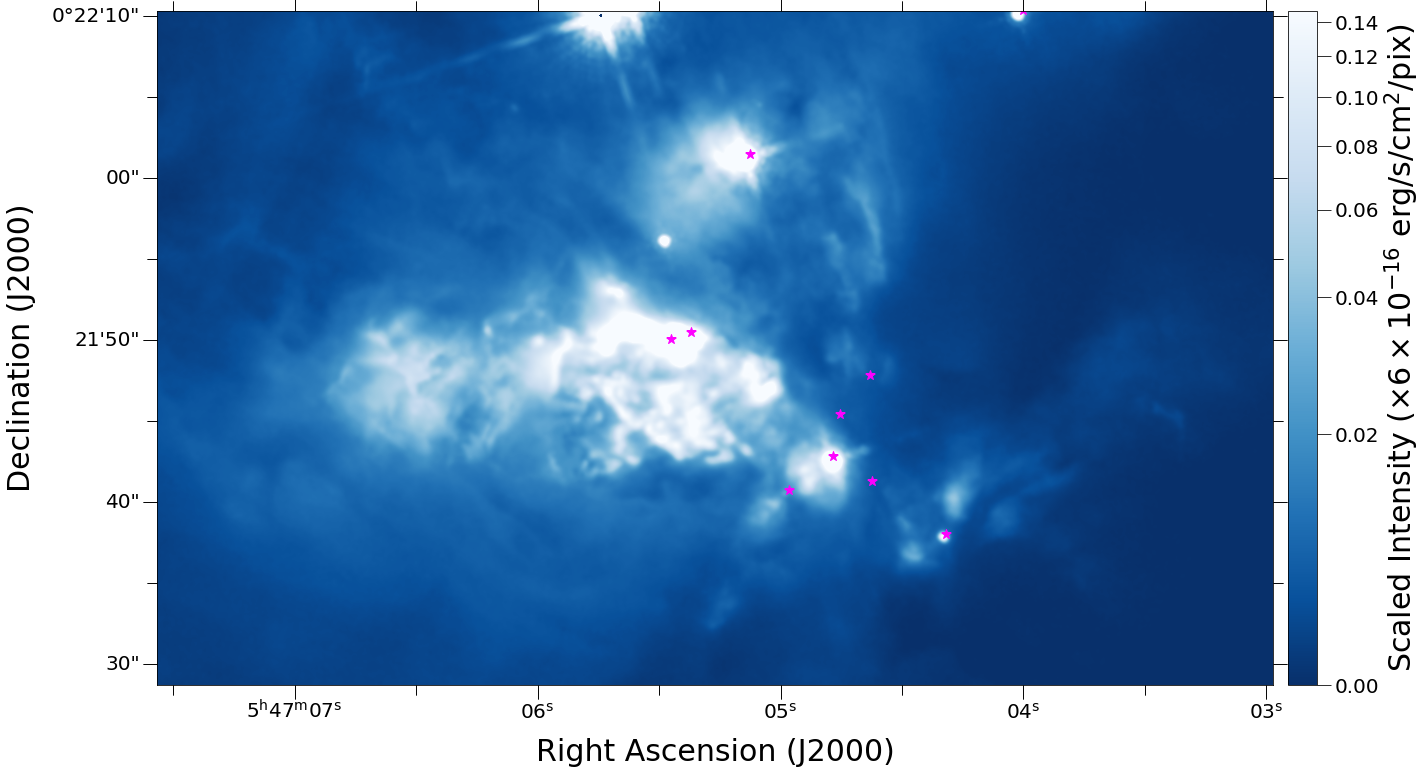

In [16]:
#plotting resulting difference image
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.utils.data import get_pkg_data_filename
from astropy.visualization import ZScaleInterval, ImageNormalize, PercentileInterval
from astropy.visualization.stretch import SinhStretch, AsinhStretch, LogStretch
from astropy.visualization.wcsaxes import WCSAxesSubplot
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
import matplotlib.ticker
from matplotlib.ticker import LogFormatter, LogLocator, FixedLocator, FixedFormatter
                
#formatting for ticks
# plt.rcParams['xtick.labeltop'] = plt.rcParams['xtick.labelright'] = False
plt.rcParams['xtick.major.size'] = 14
plt.rcParams['ytick.major.size'] = 14

#coordinates for IRS or HOPS objects
ra_list  = ['5h47m4.785s','5h47m4.755s','5h47m4.631s','5h47m4.317s','5h47m4.623s',\
            '5h47m4.967s','5h47m5.367s','5h47m5.451s','5h47m5.125s', '5h47m5.819s', '05h47m4.004s']
dec_list = ['0d21m42.85s', '0d21m45.45s', '0d21m47.82s', '0d21m38.03s', '0d21m41.30s', \
            '0d21m40.74s', '0d21m50.51s', '0d21m50.08s', '0d22m1.46s', '+00d22m37.45s', '+00d22m10.38s']
coord_sky_list = [SkyCoord(ra=i, dec=j, frame='icrs') for i,j in zip(ra_list, dec_list)]

coord_pix_list = []
for c in coord_sky_list:
    coord_pix_list.append(skycoord_to_pixel(c, WCS(hdu_header_list[0])))


#opening a figure
fig = plt.figure(figsize=(20,20))
wcs = WCS(hdu_header_list[2])
ax = plt.subplot(projection=wcs)

#plotting
interval = PercentileInterval(99.5) # MinMaxInterval() # PercentileInterval(99.2)
data_interval = interval.get_limits(epoch1) #automated
# ds9_min = -2 # -100e-5 #-8.41819e-05
# ds9_max = 0
norm = ImageNormalize(stretch=AsinhStretch(), vmin=data_interval[0], vmax=data_interval[1]) #uatomated
# norm = ImageNormalize(stretch=LogStretch(), vmin=ds9_min, vmax=ds9_max) #by hand
# norm = ImageNormalize(stretch=AsinhStretch(), vmin=-8e-18, vmax=8e-18)
# norm = ImageNormalize(stretch=LogStretch(), vmin=0.1e-18, vmax=100e-18)
im = ax.imshow(epoch1 , norm=norm, origin='lower', cmap='Blues_r')
hops_sources = [ax.scatter(c_pair[0], c_pair[1], color='fuchsia', marker='*', s=100) for c_pair in coord_pix_list]

#general formatting
ax.set_xlim(470, 1530) # ax.set_xlim(700, 1500) 
ax.set_ylim(350, 990) # ax.set_ylim(1050, 1850) 
# ax.coords.grid(True, color='black', ls='solid', linewidth=0.75) #adding gridlines
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=30)
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=30)   
ax.coords[0].set_minor_frequency(2) #for minor ticks
ax.coords[1].set_minor_frequency(2)
ax.coords[0].display_minor_ticks(True)
ax.coords[1].display_minor_ticks(True)
ax.tick_params(axis='x', labelbottom=True, labeltop=False, labelright=False) 
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', which='minor', length=10)
ax.tick_params(axis='y', which='minor', length=10)
# ax.invert_yaxis() #done because it's nicer with declination increasing going up
# ax.invert_xaxis()

#colorbar, see 3rd answer from https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax) 

#color bar label and tick labels
# sub_labels = [2]
# cbar.locator = LogLocator(base=10, subs=sub_labels)
cbar.ax.tick_params(labelsize=20)
cbar.update_ticks()
cbar.ax.yaxis.get_offset_text().set_fontsize(0)
cbar.set_label(label=r'$\rm Scaled~Intensity~(\times 6 \times {10}^{-16} \ erg/s/{cm}^{2}/pix)$', size=30)
# cbar_tickfont = [cbar.ax.set_yticklabels(labels=cbar.ax.get_yticklabels())[i].set_fontweight('normal') for i in range(len(cbar.ax.get_yticklabels()))]
    
#adding a compass
# theta_wcs = (135+180)*np.pi/180
# x, y, arrow_length = 0.845, 0.755, 0.1
# compass_N = ax.annotate('N', xy=(x, y), xytext=(x-arrow_length*1.5*np.sin(theta_wcs+np.pi/3.), \
#             y+arrow_length*np.cos(theta_wcs+np.pi/3.)), 
#             arrowprops=dict(arrowstyle='<-', lw=3, color='white'), color='white',
#             ha='center', va='center', fontsize=35, rotation=25,
#             xycoords='subfigure fraction') #ax.transAxes)
# compass_E = ax.annotate('E', xy=(x, y), xytext=(x-arrow_length*3/4*np.cos(theta_wcs+np.pi/2.), \
#             y-arrow_length*3/6*np.sin(theta_wcs+np.pi/2.)), 
#             arrowprops=dict(arrowstyle='<-', lw=3, color='white'), color='white',
#             ha='center', va='center', fontsize=35, rotation=25,
#             xycoords='subfigure fraction') #ax.transAxes)
    
plt.savefig('361A_f160w_epoch_1.png', dpi=300, bbox_inches="tight")
plt.savefig('361A_f160w_epoch_1.pdf', dpi=300, bbox_inches="tight")

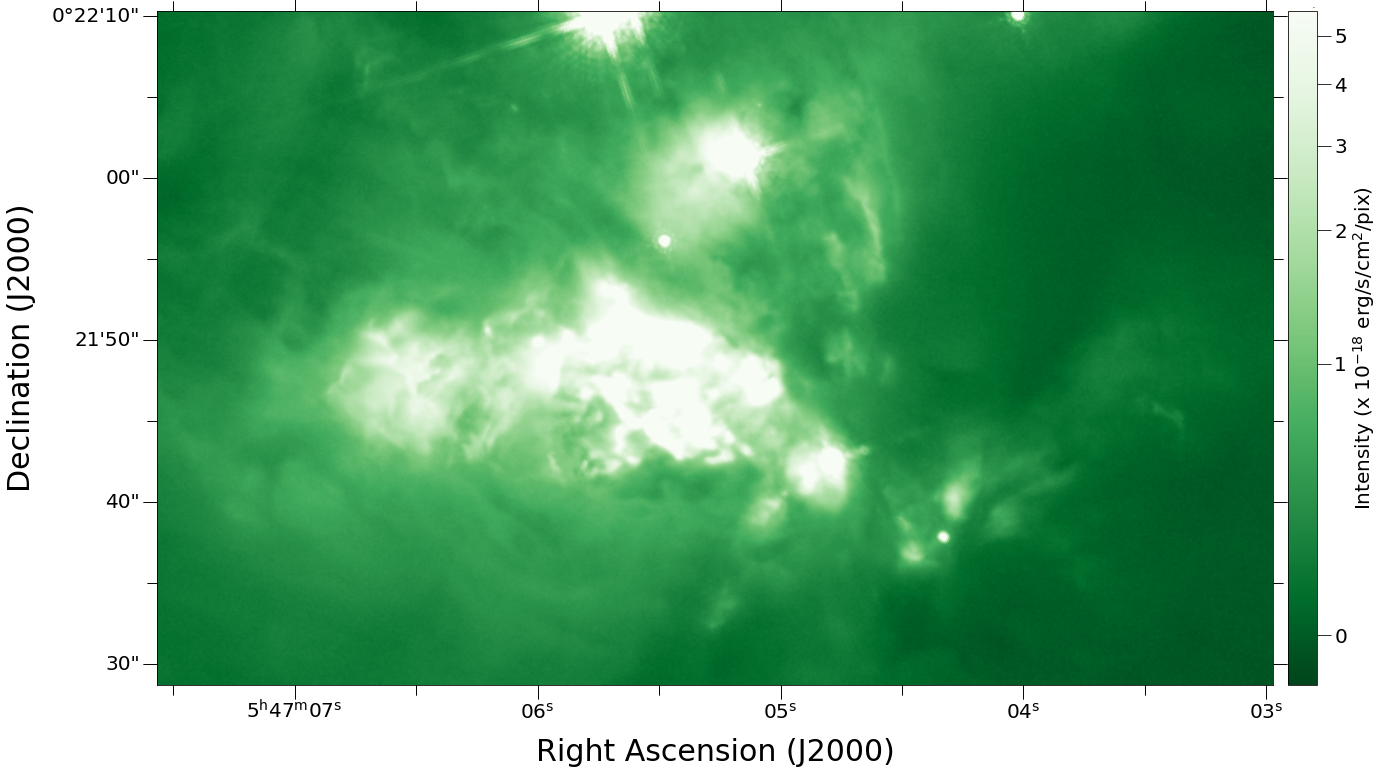

In [17]:
#plotting resulting image
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.utils.data import get_pkg_data_filename
from astropy.visualization import ZScaleInterval, ImageNormalize, PercentileInterval
from astropy.visualization.stretch import SinhStretch, AsinhStretch, LogStretch
from astropy.visualization.wcsaxes import WCSAxesSubplot
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
import matplotlib.ticker
from matplotlib.ticker import LogFormatter, LogLocator, FixedLocator, FixedFormatter
                
#minor formatting for ticks
# plt.rcParams['xtick.labeltop'] = plt.rcParams['xtick.labelright'] = False
plt.rcParams['xtick.major.size'] = 14
plt.rcParams['ytick.major.size'] = 14

#plotting IRS or HOPS objects
ra_list  = ['5h47m4.785s','5h47m4.755s','5h47m4.631s','5h47m4.317s','5h47m4.623s','5h47m4.967s','5h47m5.367s','5h47m5.451s','5h47m5.125s']
dec_list = ['0d21m42.85s', '0d21m45.45s', '0d21m47.82s', '0d21m38.03s', '0d21m41.30s', '0d21m40.74s', '0d21m50.51s', '0d21m50.08s', '0d22m1.46s']
coord_sky_list = [SkyCoord(ra=i, dec=j, frame='icrs') for i,j in zip(ra_list, dec_list)]

coord_pix_list = []
for c in coord_sky_list:
    coord_pix_list.append(skycoord_to_pixel(c, WCS(hdu_header_list[2])))

fig = plt.figure(figsize=(20,20))
wcs = WCS(hdu_header_list[1])
ax = plt.subplot(projection=wcs)

#plotting
interval = PercentileInterval(99)
data_interval = interval.get_limits(hdu_data_list[0])
ds9_min = -1.64092e-17
ds9_max = 3.19425e-16
norm = ImageNormalize(stretch=AsinhStretch(), vmin=data_interval[0], vmax=data_interval[1])
# norm = ImageNormalize(stretch=SinhStretch(), vmin=ds9_min, vmax=ds9_max)
# norm = ImageNormalize(stretch=AsinhStretch(), vmin=-8e-18, vmax=8e-18)
# norm = ImageNormalize(stretch=LogStretch(), vmin=0.1e-18, vmax=100e-18)
im = ax.imshow(hdu_data_list[0], norm=norm, origin='lower', cmap='Greens_r')
# hops_sources = [ax.scatter(c_pair[0], c_pair[1], color='gold', marker='+', s=100) for c_pair in coord_pix_list]


#adding a sofia region circle...
# from matplotlib.patches import Circle
# # from photutils.aperture import CircularAperture #if you want to play with aperture tricks or photometry
# sofia_radec_str = '05h47m04.63s 00d21m59.0s' # the coordinate centered on protostars:'05h47m04.78 00d21m42.8s'
# sofia_skycoord = SkyCoord(sofia_radec_str, frame=FK5, unit=(u.hourangle, u.deg))
# x, y = (skycoord_to_pixel(sofia_skycoord, wcs=WCS(hdu_header_list[1])))
# # x = 515
# # y = 605
# R_sof = 4/hst_pixsize # 20 # 9.9/hst_pixsize/2 # 20 
# sofia_reg = ax.add_patch(Circle((x,y), radius=R_sof, edgecolor='fuchsia', fill=False))

#general formatting
ax.set_xlim(470, 1530) # ax.set_xlim(700, 1500) 
ax.set_ylim(350, 990) # ax.set_ylim(1050, 1850) 
# ax.coords.grid(True, color='black', ls='solid', linewidth=0.75) #adding gridlines
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=30)
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=30)   
ax.coords[0].set_minor_frequency(2) #for minor ticks
ax.coords[1].set_minor_frequency(2)
ax.coords[0].display_minor_ticks(True)
ax.coords[1].display_minor_ticks(True)
ax.tick_params(axis='x', labelbottom=True, labeltop=False, labelright=False) 
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', which='minor', length=10)
ax.tick_params(axis='y', which='minor', length=10)
# ax.invert_yaxis() #done because it's nicer with declination increasing going up
# ax.invert_xaxis()


#colorbar, see 3rd answer from https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax) 

#color bar label and tick labels
# sub_labels = [2]
# cbar.locator = LogLocator(base=10, subs=sub_labels)
cbar.ax.tick_params(labelsize=20)
cbar.update_ticks()
cbar.ax.yaxis.get_offset_text().set_fontsize(0)
cbar.set_label(label=r'$\rm Intensity~(x~{10}^{-18}~erg/s/{cm}^{2}/pix)$', size=20)
# cbar_tickfont = [cbar.ax.set_yticklabels(labels=cbar.ax.get_yticklabels())[i].set_fontweight('normal') for i in range(len(cbar.ax.get_yticklabels()))]
    
#adding a compass
# theta_wcs = (135+180)*np.pi/180
# x, y, arrow_length = 0.845, 0.755, 0.1
# compass_N = ax.annotate('N', xy=(x, y), xytext=(x-arrow_length*1.5*np.sin(theta_wcs+np.pi/3.), \
#             y+arrow_length*np.cos(theta_wcs+np.pi/3.)), 
#             arrowprops=dict(arrowstyle='<-', lw=3, facecolor='white'),
#             ha='center', va='center', fontsize=35, rotation=25,
#             xycoords='subfigure fraction') #ax.transAxes)
# compass_E = ax.annotate('E', xy=(x, y), xytext=(x-arrow_length*3/4*np.cos(theta_wcs+np.pi/2.), \
#             y-arrow_length*3/6*np.sin(theta_wcs+np.pi/2.)), 
#             arrowprops=dict(arrowstyle='<-', lw=3, facecolor='white'),
#             ha='center', va='center', fontsize=35, rotation=25,
#             xycoords='subfigure fraction') #ax.transAxes)

# plt.savefig('f164n_epoch_2.png', dpi=300, bbox_inches="tight")

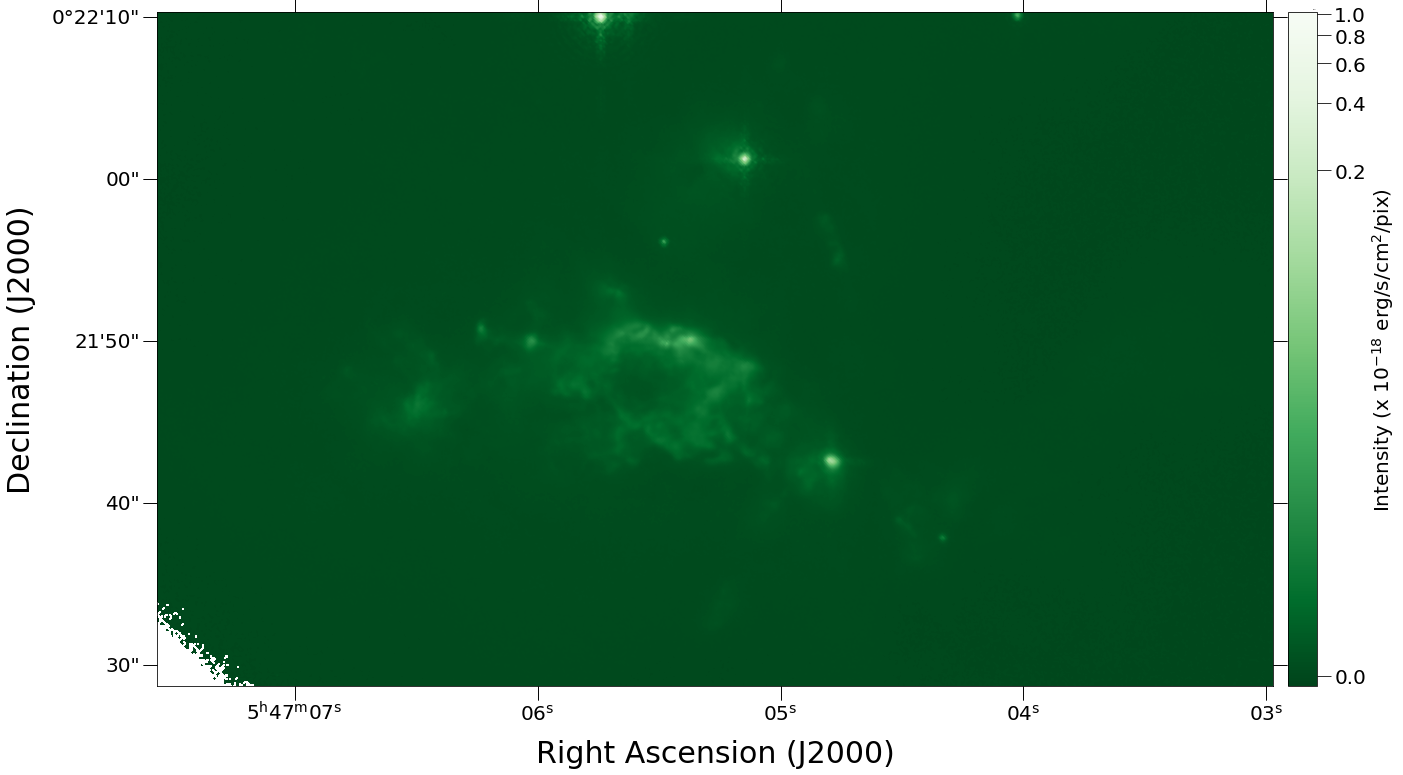

In [18]:
#plotting resulting image
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.utils.data import get_pkg_data_filename
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.visualization.stretch import SinhStretch, AsinhStretch, LogStretch
from astropy.visualization.wcsaxes import WCSAxesSubplot
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
import matplotlib.ticker
from matplotlib.ticker import LogFormatter, LogLocator, FixedLocator, FixedFormatter
                
#minor formatting for ticks
# plt.rcParams['xtick.labeltop'] = plt.rcParams['xtick.labelright'] = False
plt.rcParams['xtick.major.size'] = 14
plt.rcParams['ytick.major.size'] = 14

#plotting IRS or HOPS objects
ra_list  = ['5h47m4.785s','5h47m4.755s','5h47m4.631s','5h47m4.317s','5h47m4.623s','5h47m4.967s','5h47m5.367s','5h47m5.451s','5h47m5.125s']
dec_list = ['0d21m42.85s', '0d21m45.45s', '0d21m47.82s', '0d21m38.03s', '0d21m41.30s', '0d21m40.74s', '0d21m50.51s', '0d21m50.08s', '0d22m1.46s']
coord_sky_list = [SkyCoord(ra=i, dec=j, frame='icrs') for i,j in zip(ra_list, dec_list)]

coord_pix_list = []
for c in coord_sky_list:
    coord_pix_list.append(skycoord_to_pixel(c, WCS(hdu_header_list[2])))

fig = plt.figure(figsize=(20,20))
wcs = WCS(hdu_header_list[2])
ax = plt.subplot(projection=wcs)

#plotting
interval = MinMaxInterval()  # PercentileInterval(99)
data_interval = interval.get_limits(hdu_data_list[1])
ds9_min = -1.64092e-17
ds9_max = 3.19425e-16
norm = ImageNormalize(stretch=LogStretch(), vmin=data_interval[0], vmax=data_interval[1])
# norm = ImageNormalize(stretch=SinhStretch(), vmin=ds9_min, vmax=ds9_max)
# norm = ImageNormalize(stretch=AsinhStretch(), vmin=-8e-18, vmax=8e-18)
# norm = ImageNormalize(stretch=LogStretch(), vmin=0.1e-18, vmax=100e-18)
im = ax.imshow(hdu_data_list[1] , norm=norm, origin='lower', cmap='Greens_r')
# hops_sources = [ax.scatter(c_pair[0], c_pair[1], color='gold', marker='+', s=100) for c_pair in coord_pix_list]

#general formatting
ax.set_xlim(470, 1530) # ax.set_xlim(700, 1500) 
ax.set_ylim(350, 990) # ax.set_ylim(1050, 1850) 
# ax.coords.grid(True, color='black', ls='solid', linewidth=0.75) #adding gridlines
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=30)
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=30)   
ax.tick_params(axis='x', labelbottom=True, labeltop=False, labelright=False)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
# ax.invert_yaxis() #done because it's nicer with declination increasing
# ax.invert_xaxis() #done because it's nicer with declination increasing

#colorbar, see 3rd answer from https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax) 

#color bar label and tick labels
# sub_labels = [2]
# cbar.locator = LogLocator(base=10, subs=sub_labels)
cbar.ax.tick_params(labelsize=20)
cbar.update_ticks()
cbar.ax.yaxis.get_offset_text().set_fontsize(0)
cbar.set_label(label=r'$\rm Intensity~(x~{10}^{-18}~erg/s/{cm}^{2}/pix)$', size=20)
# cbar_tickfont = [cbar.ax.set_yticklabels(labels=cbar.ax.get_yticklabels())[i].set_fontweight('normal') for i in range(len(cbar.ax.get_yticklabels()))]
    
# plt.savefig('f167n_epoch_2.png', dpi=300, bbox_inches="tight")

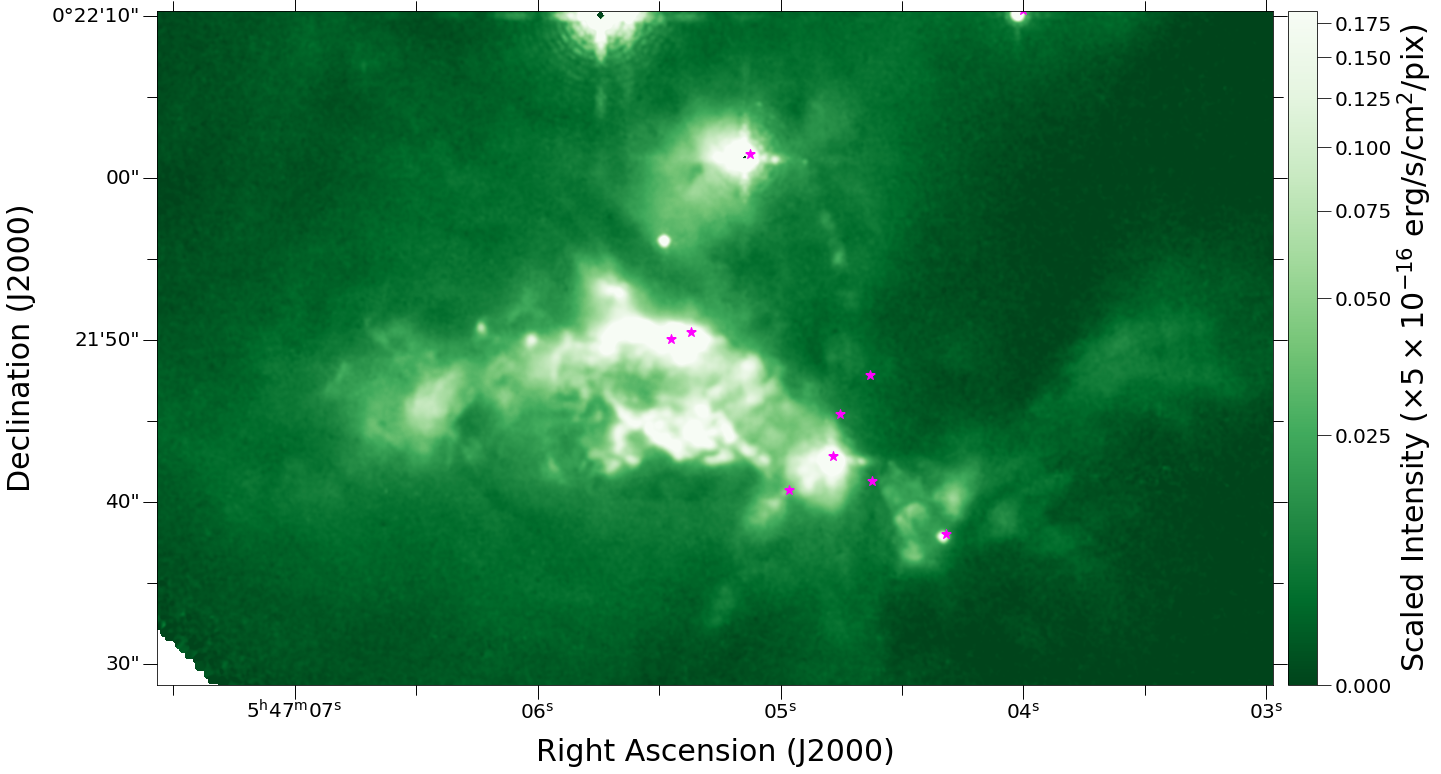

In [19]:
#plotting resulting image
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.utils.data import get_pkg_data_filename
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.visualization.stretch import SinhStretch, AsinhStretch, LogStretch
from astropy.visualization.wcsaxes import WCSAxesSubplot
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
import matplotlib.ticker
from matplotlib.ticker import LogFormatter, LogLocator, FixedLocator, FixedFormatter
                
#minor formatting for ticks
# plt.rcParams['xtick.labeltop'] = plt.rcParams['xtick.labelright'] = False
plt.rcParams['xtick.major.size'] = 14
plt.rcParams['ytick.major.size'] = 14

#plotting IRS or HOPS objects
ra_list  = ['5h47m4.785s','5h47m4.755s','5h47m4.631s','5h47m4.317s','5h47m4.623s',\
            '5h47m4.967s','5h47m5.367s','5h47m5.451s','5h47m5.125s', '5h47m5.819s', '05h47m4.004s']
dec_list = ['0d21m42.85s', '0d21m45.45s', '0d21m47.82s', '0d21m38.03s', '0d21m41.30s', \
            '0d21m40.74s', '0d21m50.51s', '0d21m50.08s', '0d22m1.46s', '+00d22m37.45s', '+00d22m10.38s']
coord_sky_list = [SkyCoord(ra=i, dec=j, frame='icrs') for i,j in zip(ra_list, dec_list)]

coord_pix_list = []
for c in coord_sky_list:
    coord_pix_list.append(skycoord_to_pixel(c, WCS(hdu_header_list[1])))

fig = plt.figure(figsize=(20,20))
wcs = WCS(hdu_header_list[1])
ax = plt.subplot(projection=wcs)

#plotting
interval = PercentileInterval(99.5)
data_interval = interval.get_limits(epoch2_synth)
ds9_min = 0
ds9_max = 0.392423 # 100e-5 #8.47856e-05 
norm = ImageNormalize(stretch=AsinhStretch(), vmin=data_interval[0], vmax=data_interval[1])
# norm = ImageNormalize(stretch=LogStretch(), vmin=ds9_min, vmax=ds9_max)
# norm = ImageNormalize(stretch=AsinhStretch(), vmin=-8e-18, vmax=8e-18)
# norm = ImageNormalize(stretch=LogStretch(), vmin=0.1e-18, vmax=100e-18)
im = ax.imshow(epoch2_synth, norm=norm, origin='lower', cmap='Greens_r')
hops_sources = [ax.scatter(c_pair[0], c_pair[1], color='fuchsia', marker='*', s=100) for c_pair in coord_pix_list]

#general formatting
ax.set_xlim(470, 1530) # ax.set_xlim(700, 1500) 
ax.set_ylim(350, 990) # ax.set_ylim(1050, 1850) 
# ax.coords.grid(True, color='black', ls='solid', linewidth=0.75) #adding gridlines
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=30)
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=30)   
ax.coords[0].set_minor_frequency(2) #for minor ticks
ax.coords[1].set_minor_frequency(2)
ax.coords[0].display_minor_ticks(True)
ax.coords[1].display_minor_ticks(True)
ax.tick_params(axis='x', labelbottom=True, labeltop=False, labelright=False) 
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', which='minor', length=10)
ax.tick_params(axis='y', which='minor', length=10)
# ax.invert_yaxis() #done because it's nicer with declination increasing going up
# ax.invert_xaxis()

#colorbar, see 3rd answer from https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax) 

#color bar label and tick labels
# sub_labels = [2]
# cbar.locator = LogLocator(base=10, subs=sub_labels)
cbar.ax.tick_params(labelsize=20)
cbar.update_ticks()
cbar.ax.yaxis.get_offset_text().set_fontsize(0)
cbar.set_label(label=r'$\rm Scaled~Intensity~(\times 5 \times {10}^{-16} \ erg/s/{cm}^{2}/pix)$', size=30)
# cbar_tickfont = [cbar.ax.set_yticklabels(labels=cbar.ax.get_yticklabels())[i].set_fontweight('normal') for i in range(len(cbar.ax.get_yticklabels()))]
    
# #adding a compass
# theta_wcs = (135+180)*np.pi/180
# x, y, arrow_length = 0.845, 0.755, 0.1
# compass_N = ax.annotate('N', xy=(x, y), xytext=(x-arrow_length*1.5*np.sin(theta_wcs+np.pi/3.), \
#             y+arrow_length*np.cos(theta_wcs+np.pi/3.)), 
#             arrowprops=dict(arrowstyle='<-', lw=3, color='white'), color='white',
#             ha='center', va='center', fontsize=35, rotation=25,
#             xycoords='subfigure fraction') #ax.transAxes)
# compass_E = ax.annotate('E', xy=(x, y), xytext=(x-arrow_length*3/4*np.cos(theta_wcs+np.pi/2.), \
#             y-arrow_length*3/6*np.sin(theta_wcs+np.pi/2.)), 
#             arrowprops=dict(arrowstyle='<-', lw=3, color='white'), color='white',
#             ha='center', va='center', fontsize=35, rotation=25,
#             xycoords='subfigure fraction') #ax.transAxes)
    
plt.savefig('f160w_synth_epoch_2.png', dpi=300, bbox_inches="tight")
plt.savefig('f160w_synth_epoch_2.pdf', dpi=300, bbox_inches="tight")

In [16]:
# grabbing region files for use for labeling images
# https://docs.astropy.org/en/stable/nddata/utils.html#cutout-images
from astropy import units as u
from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord, FK5, ICRS
from photutils.aperture import EllipticalAperture

#known pixel size
hst_pixsize = 0.12825 #arcsec

#reading in the .reg files made using DS9 
# f = open('moving_blobs.reg', 'r')
f1 = open('../measurements_by_hand/epoch1_361c_byhand_ellipses_ordered.reg', 'r')
f2 = open('../measurements_by_hand/epoch2_361c_byhand_ellipses_ordered.reg', 'r')
file1_output = []
file2_output = []

#looping through files
for line in f1:
    file1_output.append(line)
f1.close()

for line in f2:
    file2_output.append(line)
f2.close()

#fix file contents
#contents are ra, dec, width, height, rotation
file1_output = [i[8:-2] for i in file1_output[3:]]
file2_output = [i[8:-2] for i in file2_output[3:]]

#next step is for image, loop through all regions and make a list of region properties
ra_diff_list = []
dec_diff_list = []
ra_pix_list = []
dec_pix_list = []
rad_a_list = []
rad_b_list = []
rotation_list = []

#coordinate details very much compacted (likely better ways to do this)
split_params1 = [i.split(',') for i in file1_output]
split_params2 = [i.split(',') for i in file2_output]
ra_hms_list = [(ra1[0].split(':')[0]+'h' + ra1[0].split(':')[1]+'m' + ra1[0].split(':')[2]+'s', \
                ra2[0].split(':')[0]+'h' + ra2[0].split(':')[1]+'m' + ra2[0].split(':')[2]+'s') \
               for ra1, ra2 in zip(split_params1, split_params2)]
dec_dms_list = [(dec1[1].split(':')[0]+'d' + dec1[1].split(':')[1]+'m' + dec1[1].split(':')[2]+'s', \
                 dec2[1].split(':')[0]+'d' + dec2[1].split(':')[1]+'m' + dec2[1].split(':')[2]+'s') \
                for dec1, dec2 in zip(split_params1, split_params2)]

#offsets that can be used for finding knot offsets between epochs
pos_list = [[SkyCoord(ra[0]+' '+dec[0], frame=FK5, unit=(u.hourangle, u.deg)), \
             SkyCoord(ra[1]+' '+dec[1], frame=FK5, unit=(u.hourangle, u.deg))] \
             for ra, dec in zip(ra_hms_list, dec_dms_list)]
ra_diff_list = [(i[1].ra.value - i[0].ra.value) * 24 * 60 for i in pos_list]
dec_diff_list = [(i[1].dec.value - i[0].dec.value) * 60 * 60 for i in pos_list]

#this isn't working for some reason...skycoord_to_pixel doesn't seem to like the units? not sure
ra_pix_list = [[skycoord_to_pixel(i[0], wcs=WCS(hdu_header_list[0]))[0], \
               skycoord_to_pixel(i[1], wcs=WCS(hdu_header_list[1]))[0]] \
               for i in pos_list]
dec_pix_list = [[skycoord_to_pixel(i[0], wcs=WCS(hdu_header_list[0]))[1], \
               skycoord_to_pixel(i[1], wcs=WCS(hdu_header_list[1]))[1]] \
               for i in pos_list]

#aperture size details in pixels (?)
rad_a_list = [[1./hst_pixsize * float(rad_a1[2][:-1]), 1./hst_pixsize * float(rad_a2[2][:-1])]
               for rad_a1, rad_a2 in zip(split_params1, split_params2)]
rad_b_list = [[1./hst_pixsize * float(rad_b1[3][:-1]), 1./hst_pixsize * float(rad_b2[3][:-1])]
               for rad_b1, rad_b2 in zip(split_params1, split_params2)]
rotation_list = [[float(rot1[4]), float(rot2[4])] for rot1, rot2 in zip(split_params1, split_params2)]

# #making apertures
aperture_list = []
aper_mask_list = []
for i in range(len(ra_pix_list)):
    aperture_list.append(EllipticalAperture([ra_pix_list[i][1], dec_pix_list[i][1]], 
                                       rad_a_list[i][1], rad_b_list[i][1], theta=rotation_list[i][1]))
    aper_mask_list.append(aperture_list[i].to_mask())

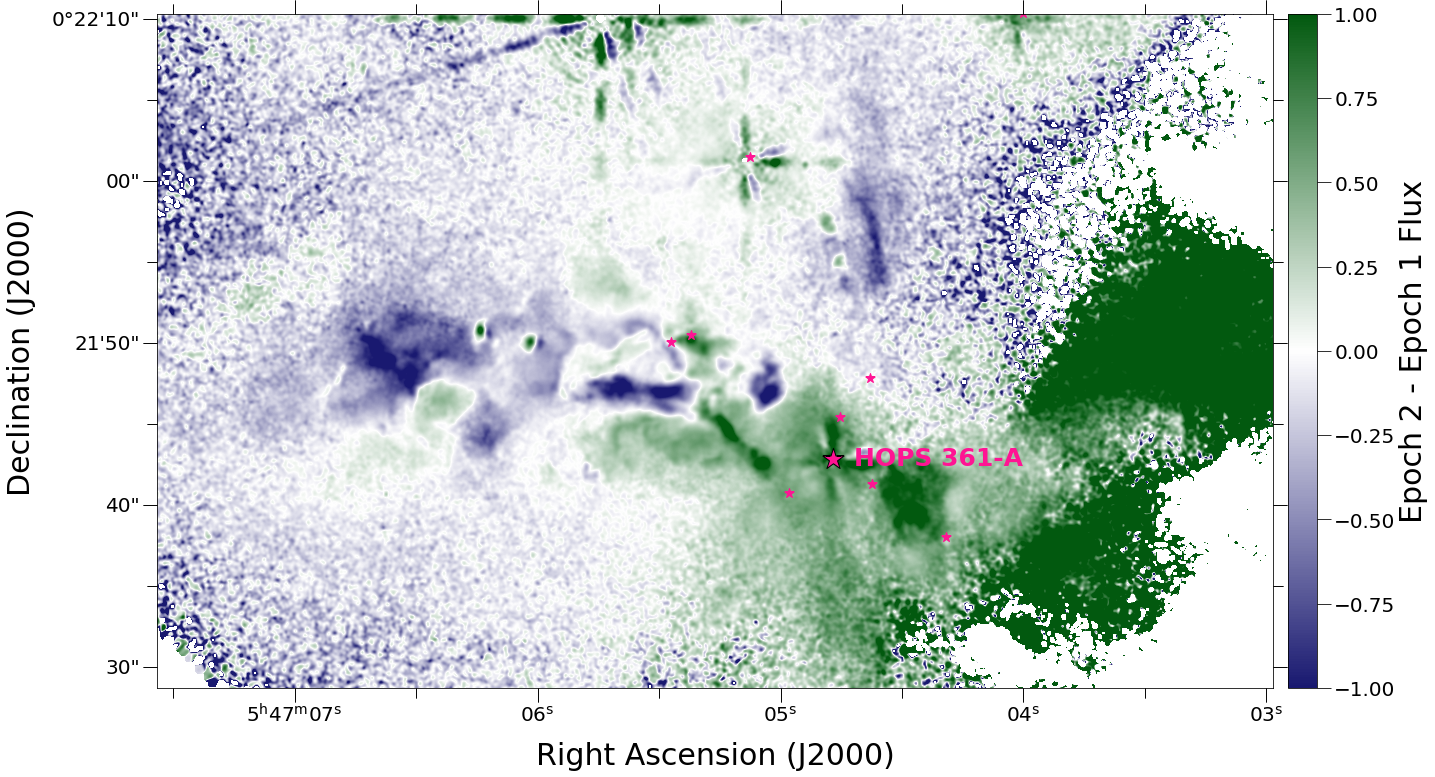

In [20]:
#known pixel size
hst_pixsize = 0.12825 #arcsec

#plotting resulting image
from astropy.coordinates import SkyCoord, FK5
from astropy import units as u
from astropy.utils.data import get_pkg_data_filename
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.visualization.stretch import SinhStretch, AsinhStretch, LogStretch
from astropy.visualization.wcsaxes import WCSAxesSubplot
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
from matplotlib.colors import TwoSlopeNorm
import matplotlib.ticker
from matplotlib.ticker import LogFormatter, LogLocator, FixedLocator, FixedFormatter

#minor formatting for ticks
# plt.rcParams['xtick.labeltop'] = plt.rcParams['xtick.labelright'] = False
plt.rcParams['xtick.major.size'] = 14
plt.rcParams['ytick.major.size'] = 14

#plotting IRS or HOPS objects
#note the last two added on are respectively HOPS 335 and HOPS 366
#the rest are taken from the table in Cheng et al 2021
ra_list  = ['5h47m4.785s','5h47m4.755s','5h47m4.631s','5h47m4.317s','5h47m4.623s',\
            '5h47m4.967s','5h47m5.367s','5h47m5.451s','5h47m5.125s', '5h47m5.819s', '05h47m4.004s']
dec_list = ['0d21m42.85s', '0d21m45.45s', '0d21m47.82s', '0d21m38.03s', '0d21m41.30s', \
            '0d21m40.74s', '0d21m50.51s', '0d21m50.08s', '0d22m1.46s', '+00d22m37.45s', '+00d22m10.38s']
coord_sky_list = [SkyCoord(ra=i, dec=j, frame='icrs') for i,j in zip(ra_list, dec_list)]
size_list = [500, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
color_list = [ 'deeppink', 'deeppink', 'deeppink', \
              'deeppink', 'deeppink', 'deeppink', 'deeppink', 'deeppink', 'deeppink', 'deeppink', 'deeppink']
ec_list = ['black', None, None, None, None, None, None, None, None, None, None]

coord_pix_list = []
for c in coord_sky_list:
    coord_pix_list.append(skycoord_to_pixel(c, WCS(hdu_header_list[2])))

    
fig = plt.figure(figsize=(20,20))
wcs = WCS(hdu_header_list[2])
ax = plt.subplot(projection=wcs)

#plotting
interval = MinMaxInterval()
data_interval = interval.get_limits(epoch_diff)
ds9_min = -1 #-8e-05
ds9_max = 1 # 2e-05
norm = ImageNormalize(stretch=LogStretch(), vmin=data_interval[0], vmax=data_interval[1])
# norm = ImageNormalize(stretch=AsinhStretch(), vmin=ds9_min, vmax=ds9_max)
# norm = ImageNormalize(stretch=SinhStretch(), vmin=ds9_min, vmax=ds9_max)
# norm = ImageNormalize(stretch=AsinhStretch(), vmin=-8e-18, vmax=8e-18)
# norm = ImageNormalize(stretch=LogStretch(), vmin=0.1e-18, vmax=100e-18)

#adding a sofia region circle...
# from matplotlib.patches import Circle
# # from photutils.aperture import CircularAperture #if you want to play with aperture tricks or photometry
# sofia_radec_str = '05h47m04.723s 00d21m57.84s' # the coordinate centered on protostars:'05h47m04.78 00d21m42.8s'
# sofia_skycoord = SkyCoord(sofia_radec_str, frame=FK5, unit=(u.hourangle, u.deg))
# x, y = (skycoord_to_pixel(sofia_skycoord, wcs=WCS(hdu_header_list[1])))
# # x = 515
# # y = 605
# R_sof = 3.15/hst_pixsize # 20 # 9.9/hst_pixsize/2 # 20 
# sofia_reg = ax.add_patch(Circle((x,y), radius=R_sof, edgecolor='deeppink', fill=False))

#numbering the region locations
# for i in range(len(aperture_list)):
#     x_pix, y_pix = aperture_list[i].positions
#     if i+1 != 1 and i+1 != 7 and i+1 != 9:
#         ax.annotate(str(i+1), (x_pix, y_pix+15), color='deeppink', fontsize=25, fontweight='demibold')
#     elif i+1 == 9:
#         ax.annotate(str(i+1), (x_pix-20, y_pix+12), color='deeppink', fontsize=25, fontweight='demibold')
#     elif i+1 == 7:
#         ax.annotate(str(i+1), (x_pix+12, y_pix+4), color='deeppink', fontsize=25, fontweight='demibold')
#     elif i+1 == 1:
#         ax.annotate(str(i+1), (x_pix+4, y_pix+1), color='deeppink', fontsize=25, fontweight='demibold')
        

#labeling the hops protostellar sources
import matplotlib.colors #to setup a new color map that is friendly to colorblindness, can also see https://www.color-blindness.com/coblis-color-blindness-simulator/
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", \
                                                          ['midnightblue', 'xkcd:white', 'xkcd:deep green']) #dark pastel green
                                                        # ["midnightblue","white","forestgreen"])
# im = ax.imshow(-np.array(img_solved)/8.0096e-13-hdu_data_list[2]/np.max(hdu_data_list[2]) , norm=norm, origin='lower', cmap=cmap)#'seismic')
# stretch_data = np.arcsinh((-np.array(img_solved)/8.0096e-13-hdu_data_list[2]/np.max(hdu_data_list[2]))/0.1)/np.sinh(1/0.1)
# stretch_data = -np.array(img_solved)/8.0096e-13-hdu_data_list[2]/np.max(hdu_data_list[2])
# stretch_data = np.sinh((epoch2_synth/1e-18/1172.3 - epoch1/1e-18/54.5795/2 +0.16842)*2.25) / np.sinh(1./2.25)
im = ax.imshow(epoch_diff , norm=TwoSlopeNorm(0, vmin=-1, vmax=1), origin='lower', cmap=cmap)#'seismic')
hops_sources = [ax.scatter(c_pair[0], c_pair[1], color=color_pick, marker='*', s=mark_size, linewidths=1, edgecolor=ec_pick) for c_pair,mark_size,color_pick, ec_pick in zip(coord_pix_list, size_list,color_list, ec_list)]
ax.annotate('HOPS 361-A', (coord_pix_list[0][0]+20, coord_pix_list[0][1]-6), color='deeppink', fontsize=25, fontweight='demibold')

#general formatting
# ax.set_xlim(200, 1000)
# ax.set_ylim(300, 1100)
ax.set_xlim(470, 1530) # ax.set_xlim(700, 1500) 
ax.set_ylim(350, 990) # ax.set_ylim(1050, 1850) 
# ax.coords.grid(True, color='black', ls='solid', linewidth=1) #adding gridlines
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=30)
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=30)   
ax.coords[0].set_minor_frequency(2) #for minor ticks
ax.coords[1].set_minor_frequency(2)
ax.coords[0].display_minor_ticks(True)
ax.coords[1].display_minor_ticks(True)
ax.tick_params(axis='x', labelbottom=True, labeltop=False, labelright=False) 
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', which='minor', length=10)
ax.tick_params(axis='y', which='minor', length=10)
# ax.invert_yaxis() #done because it's nicer with declination increasing going up
# ax.invert_xaxis()

#colorbar, see 3rd answer from https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax) 

#color bar label and tick labels
# sub_labels = [2]
# cbar.locator = LogLocator(base=10, subs=sub_labels)
cbar.ax.tick_params(labelsize=20)
cbar.update_ticks()
cbar.ax.yaxis.get_offset_text().set_fontsize(0)
cbar.set_label(label=r'Epoch 2 - Epoch 1 Flux', size=30)
# cbar_tickfont = [cbar.ax.set_yticklabels(labels=cbar.ax.get_yticklabels())[i].set_fontweight('normal') for i in range(len(cbar.ax.get_yticklabels()))]

#adding a compass
# theta_wcs = (135+180)*np.pi/180
# x, y, arrow_length = 0.845, 0.755, 0.1
# compass_N = ax.annotate('N', xy=(x, y), xytext=(x-arrow_length*1.5*np.sin(theta_wcs+np.pi/3.), \
#             y+arrow_length*np.cos(theta_wcs+np.pi/3.)), 
#             arrowprops=dict(arrowstyle='<-', lw=3, color='black'), color='black',
#             ha='center', va='center', fontsize=35, rotation=25,
#             xycoords='subfigure fraction') #ax.transAxes)
# compass_E = ax.annotate('E', xy=(x, y), xytext=(x-arrow_length*3/4*np.cos(theta_wcs+np.pi/2.), \
#             y-arrow_length*3/6*np.sin(theta_wcs+np.pi/2.)), 
#             arrowprops=dict(arrowstyle='<-', lw=3, color='black'), color='black',
#             ha='center', va='center', fontsize=35, rotation=25,
#             xycoords='subfigure fraction') #ax.transAxes)

plt.savefig('f160w_diffepoch_2_1.png', dpi=300, bbox_inches="tight")
plt.savefig('f160w_diffepoch_2_1.pdf', dpi=300, bbox_inches="tight")